# Spark Experiment

In [1]:
# Import findspark
import findspark
findspark.init('/home/ubuntu/spark-3.3.1-bin-hadoop3')
findspark.find()

'/home/ubuntu/spark-3.3.1-bin-hadoop3'

In [2]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from pyspark import SparkConf, SparkContext
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import RegressionEvaluator, ClusteringEvaluator, BinaryClassificationEvaluator
from pyspark.ml.regression import LinearRegression
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.clustering import KMeans
from pyspark.sql.functions import monotonically_increasing_id, row_number
from pyspark.sql.window import Window

SEED = 42

In [3]:
from pyspark.sql import SparkSession

# The entry point into all functionality in Spark is the SparkSession class.
spark = (SparkSession
	.builder
	.appName("DS5110/CS5501: my awesome Spark program")
	.master("spark://172.31.88.97:7077")
	.config("spark.executor.memory", "1024M")
	.getOrCreate())

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


24/04/23 21:55:22 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
spark

## Read Data

In [6]:
# Split data into X and y
X_reg_train = (spark.read
               .format('csv')
               .option('inferSchema', True)
               .option('header', True)
               .load('hdfs://172.31.88.97:9000/X_reg_train_idx.csv')
              )
X_reg_test = (spark.read
               .format('csv')
               .option('inferSchema', True)
               .option('header', True)
               .load('hdfs://172.31.88.97:9000/X_reg_test_idx.csv')
              )
X_class_train = (spark.read
               .format('csv')
               .option('inferSchema', True)
               .option('header', True)
               .load('hdfs://172.31.88.97:9000/X_class_train_idx.csv')
              )
X_class_test = (spark.read
               .format('csv')
               .option('inferSchema', True)
               .option('header', True)
               .load('hdfs://172.31.88.97:9000/X_class_test_idx.csv')
              )
y_reg_train = (spark.read
               .format('csv')
               .option('inferSchema', True)
               .option('header', True)
               .load('hdfs://172.31.88.97:9000/y_reg_train_idx.csv')
              )
y_reg_test = (spark.read
               .format('csv')
               .option('inferSchema', True)
               .option('header', True)
               .load('hdfs://172.31.88.97:9000/y_reg_test_idx.csv')
              )
y_class_train = (spark.read
               .format('csv')
               .option('inferSchema', True)
               .option('header', True)
               .load('hdfs://172.31.88.97:9000/y_class_train_idx.csv')
              )
y_class_test = (spark.read
               .format('csv')
               .option('inferSchema', True)
               .option('header', True)
               .load('hdfs://172.31.88.97:9000/y_class_test_idx.csv')
              )

## Inspect Data
We will need to join X and y for each step I believe.

In [7]:
X_reg_train.show(5)

+--------+-------------------+------------------+-------------------+-------------------+
|     _c0|          dateDelta|    seatsRemaining|totalTravelDistance|    durationSeconds|
+--------+-------------------+------------------+-------------------+-------------------+
|28120237| 0.5764591848038317|0.6878736440934151| 0.5335992043260079|0.38985526700984063|
|23324511|-1.4312694411428493|1.0779777898947491|   1.02154231351557|  0.805486775199166|
|16627325| 0.9898150783810896|1.0779777898947491|-0.9088603520372959| 1.1056650866692344|
|39011620|-1.0769643895051997|0.2977694982920811| 0.2462945025647573| 0.5514897424168005|
|32887241|-0.6045576539883336|-1.652751230714589|  0.881451591169175| 1.6690766866592086|
+--------+-------------------+------------------+-------------------+-------------------+
only showing top 5 rows



In [8]:
y_reg_train.show(5)X_reg_train.count()

+--------+-------------------+
|     _c0|           baseFare|
+--------+-------------------+
|28120237| 0.3627135043459776|
|23324511|0.34768249106493015|
|16627325| 0.7786792876541005|
|39011620|-0.9753699252646759|
|32887241| 0.7034703466492904|
+--------+-------------------+
only showing top 5 rows



In [9]:
X_reg_train.count()

16000000

In [10]:
y_reg_train.count()

16000000

In [11]:
X_reg_test.count()

4000000

In [12]:
y_reg_test.count()

4000000

## Join dataframes on `_c0` index

In [16]:
reg_train = X_reg_train.join(y_reg_train, X_reg_train._c0 == y_reg_train._c0, "left").drop('_c0')
reg_test = X_reg_test.join(y_reg_test, X_reg_test._c0 == y_reg_test._c0, "left").drop('_c0')
class_train = X_class_train.join(y_class_train, X_class_train._c0 == y_class_train._c0, "left").drop('_c0')
class_test = X_class_test.join(y_class_test, X_class_test._c0 == y_class_test._c0, "left").drop('_c0')

In [17]:
reg_train.show(5)

+-------------------+------------------+-------------------+--------------------+-------------------+
|          dateDelta|    seatsRemaining|totalTravelDistance|     durationSeconds|           baseFare|
+-------------------+------------------+-------------------+--------------------+-------------------+
|-1.0179135475655914|-0.872542939111921|0.04209446660221554|-0.18279258871767431|-0.5443731286755055|
|-0.8407610217467666|1.0779777898947491|-0.7865777723620528| 0.10814946701485344| -0.223657637413589|
|-0.7817101798071584|1.0779777898947491|-1.2555255293690528|  -0.801621723132892| 0.4027962064287704|
|-0.7817101798071584|-2.042855376515923| 0.4433712814588383|  2.1447438571425477| 1.1294568054781116|
| 1.0488659203206978|1.0779777898947491| 0.5965213084307447| -0.5014434116628238| 0.7586379366127041|
+-------------------+------------------+-------------------+--------------------+-------------------+
only showing top 5 rows



In [18]:
reg_test.show(5)

+--------------------+--------------------+--------------------+-------------------+-------------------+
|           dateDelta|      seatsRemaining| totalTravelDistance|    durationSeconds|           baseFare|
+--------------------+--------------------+--------------------+-------------------+-------------------+
|  1.6393743397167806|  0.2977694982920811|  0.6416352698643295|-0.5245340510066752|0.35770316658562845|
| -0.3093034442902922|  0.2977694982920811| -1.5440174406417135| -1.535904054267367| -1.391335708572799|
|-0.07310007653185917|-0.09233464750925295| -0.2238404639536528|-0.1597019493738229| 0.9490307715059703|
| -0.8998118636863749|  0.6878736440934151| -1.0157092080642072|-0.7000229100199459|-0.3388954059016184|
| -0.3093034442902922|  0.2977694982920811|-0.23808697809057433|-0.8293304903455138|-0.6095613941596174|
+--------------------+--------------------+--------------------+-------------------+-------------------+
only showing top 5 rows



## Spark Experiment Function

In [32]:
def spark_time_algorithm(subset_prop, algorithm_name, SEED=SEED):
    '''
    algorithm_name one of 'LogReg', 'KMEANS', 'LinReg'
    '''
    if (algorithm_name == "LinReg" or algorithm_name == "KMEANS"):
        # Subset data
        reg_train_subset = reg_train.limit(int(reg_train.count() * subset_prop))
        reg_test_subset = reg_test.limit(int(reg_test.count() * subset_prop))
        # Assemble vectors for model
        numericCols = ['dateDelta', 'seatsRemaining', 'totalTravelDistance', 'durationSeconds']
        assembler = VectorAssembler(inputCols=numericCols, outputCol="features")
        train = assembler.transform(reg_train_subset)
        test = assembler.transform(reg_test_subset)
      
    elif (algorithm_name == "LogReg"):
        class_train_subset = class_train.limit(int(class_train.count() * subset_prop))
        class_test_subset = class_test.limit(int(class_test.count() * subset_prop))
        # Assemble vectors for model
        numericCols = ['dateDelta', 'baseFare', 'seatsRemaining', 'totalTravelDistance', 'durationSeconds']
        assembler = VectorAssembler(inputCols=numericCols, outputCol="features")
        train = assembler.transform(class_train_subset)
        test = assembler.transform(class_test_subset)
       
    start_time = time.time()
       
    if algorithm_name == "LogReg":
        logreg = LogisticRegression(featuresCol='features', labelCol='destinationAirport', maxIter=10, regParam=0.0, elasticNetParam=0.8)
        logreg_model = logreg.fit(train)
        predictions = logreg_model.transform(test)
        evaluator = BinaryClassificationEvaluator(labelCol='destinationAirport')
        metric = evaluator.evaluate(predictions)
                       
    elif algorithm_name == "KMEANS":
        kmeans = KMeans(featuresCol='features', predictionCol='prediction', k=2)
        model = kmeans.fit(train)
        predictions = model.transform(test)
        evaluator = ClusteringEvaluator()
        metric = evaluator.evaluate(predictions)
           
    elif algorithm_name == "LinReg":
        linreg = LinearRegression(featuresCol='features', labelCol='baseFare', maxIter=10, regParam=0.0, elasticNetParam=0.8)
        linreg_model = linreg.fit(train)
        metric = linreg_model.evaluate(test).rootMeanSquaredError
           
    end_time = time.time()
    time_delta = end_time - start_time
    return time_delta, metric

## Set proportions to loop over

In [35]:
props = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
# props = [0.1, 0.2]

## Logistic Regression Test

In [24]:
%%time
    logreg_times = []
    logreg_metrics = []
    
    for prop in props:
        print(prop)
        runtime, metric = spark_time_algorithm(prop, algorithm_name="LogReg")
        logreg_times.append(runtime)
        logreg_metrics.append(metric)
       
    print(logreg_times)
    print(logreg_metrics)

0.1


IllegalArgumentException: requirement failed: Column destinationAirport must be of type numeric but was actually of type string.

In [ ]:
logreg_frame = pd.DataFrame(list(zip(logreg_times, logreg_metrics)), columns=['Time', 'Metric'], index=props)
logreg_frame

In [ ]:
logreg_frame.Time.sum()/60

In [ ]:
plt.scatter(x=logreg_frame.index, y=logreg_frame['Time'])
plt.title('Logistic Regression Dask Run Times for Varying Input Sizes')
plt.xlabel('Proportion of Input Size')
plt.ylabel('Time (s)')

In [ ]:
logreg_frame.to_csv('spark_logreg_results.csv', index=True)

## KMeans Test

In [36]:
%%time
    kmeans_times = []
    kmeans_metrics = []
    
    for prop in props:
        print(prop)
        runtime, metric = spark_time_algorithm(prop, algorithm_name="KMEANS")
        kmeans_times.append(runtime)
        kmeans_metrics.append(metric)
       
    print(kmeans_times)
    print(kmeans_metrics)

0.1


0.2


0.3


0.4


0.5


0.6


0.7


0.8


0.9


1.0


[106.52382469177246, 130.2862823009491, 350.3130056858063, 395.32624435424805, 367.7738974094391, 450.0935151576996, 497.5072994232178, 459.1501979827881, 541.8071415424347, 691.8275828361511]
[0.4263049050198717, 0.4288969853996377, 0.428504161050077, 0.4280859185758428, 0.42969707573185734, 0.4282496560961219, 0.4272504019663235, 0.42715893845448255, 0.42949565122592587, 0.42970407502847524]
CPU times: user 2.43 s, sys: 495 ms, total: 2.93 s
Wall time: 1h 9min 55s


In [37]:
kmeans_frame = pd.DataFrame(list(zip(kmeans_times, kmeans_metrics)), columns=['Time', 'Metric'], index=props)
kmeans_frame

,Time,Metric
0.1,106.523825,0.426305
0.2,130.286282,0.428897
0.3,350.313006,0.428504
0.4,395.326244,0.428086
0.5,367.773897,0.429697
0.6,450.093515,0.428250
0.7,497.507299,0.427250
0.8,459.150198,0.427159
0.9,541.807142,0.429496
1.0,691.827583,0.429704


In [38]:
kmeans_frame.Time.sum()/60

66.51014985640843

Text(0, 0.5, 'Time (s)')

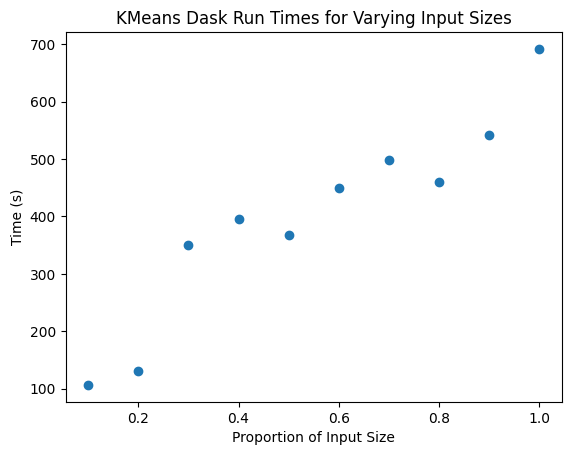

In [39]:
plt.scatter(x=kmeans_frame.index, y=kmeans_frame['Time'])
plt.title('KMeans Dask Run Times for Varying Input Sizes')
plt.xlabel('Proportion of Input Size')
plt.ylabel('Time (s)')

In [40]:
kmeans_frame.to_csv('spark_kmeans_new_results.csv', index=True)

## Linear Regression Test

In [33]:
%%time
    linreg_times = []
    linreg_metrics = []
    
    for prop in props:
        print(prop)
        runtime, metric = spark_time_algorithm(prop, algorithm_name="LinReg")
        linreg_times.append(runtime)
        linreg_metrics.append(metric)
       
    print(linreg_times)
    print(linreg_metrics)

0.1


24/04/23 22:33:25 WARN Instrumentation: [404fcc17] regParam is zero, which might cause numerical instability and overfitting.


0.2


24/04/23 22:35:26 WARN Instrumentation: [a9480e79] regParam is zero, which might cause numerical instability and overfitting.


[102.20496416091919, 106.2846188545227]
[0.8172468151195111, 0.8270474053313949]
CPU times: user 260 ms, sys: 65.8 ms, total: 325 ms
Wall time: 4min 11s


In [34]:
linreg_frame = pd.DataFrame(list(zip(linreg_times, linreg_metrics)), columns=['Time', 'Metric'], index=props)
linreg_frame

,Time,Metric
0.1,102.204964,0.817247
0.2,106.284619,0.827047


In [ ]:
linreg_frame.Time.sum()/60

Text(0, 0.5, 'Time (s)')

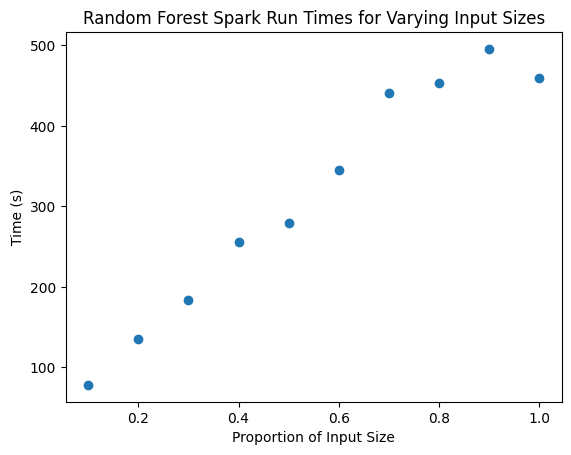

In [55]:
plt.scatter(x=linreg_frame.index, y=linreg_frame['Time'])
plt.title('Linear Regression Dask Run Times for Varying Input Sizes')
plt.xlabel('Proportion of Input Size')
plt.ylabel('Time (s)')

In [56]:
linreg_frame.to_csv('spark_linreg_results.csv', index=True)